In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [3]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
# # Saving data and labels as a pkl file
#pickle.dump(data, open("/drive/My Drive/Colab Notebooks/data.pkl", "wb"))
#pickle.dump(labels, open("/drive/My Drive/Colab Notebooks/labels.pkl", "wb"))

In [0]:
data = pickle.load(open("/drive/My Drive/Colab Notebooks/data.pkl", "rb"))
labels = pickle.load(open("/drive/My Drive/Colab Notebooks/labels.pkl", "rb"))

In [0]:
# perform one-hot encoding on the labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
# partition the data into training(60%),validation(20%) and testing(20%)
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
(trainX, validationX, trainY, validationY) = train_test_split(trainX, trainY,test_size=0.25, stratify=trainY, random_state=42)

In [0]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
# load the ResNet50V2 network, ensuring the head FC layer sets are
# left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# loop over the layers in the base model and freeze them. Now, I'm unfreezing the last 8 layers.
for layer in baseModel.layers[:-8]: 
	layer.trainable = False

In [0]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel) # apagar
headModel = Dropout(0.5)(headModel)
headModel = Dense(25, activation="softmax")(headModel)

In [0]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 20

In [0]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [15]:
# train the head of the network
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validationX, validationY),
	validation_steps=len(validationX) // BS,
	epochs=EPOCHS)

Epoch 1/20
174/174 [==============================] - 78s 448ms/step - loss: 2.9047 - accuracy: 0.1562 - val_loss: 2.5022 - val_accuracy: 0.2429
Epoch 2/20
174/174 [==============================] - 74s 425ms/step - loss: 2.5558 - accuracy: 0.2426 - val_loss: 2.2256 - val_accuracy: 0.3178
Epoch 3/20
174/174 [==============================] - 74s 425ms/step - loss: 2.2782 - accuracy: 0.3116 - val_loss: 1.9101 - val_accuracy: 0.4100
Epoch 4/20
174/174 [==============================] - 73s 422ms/step - loss: 1.9666 - accuracy: 0.4069 - val_loss: 1.7944 - val_accuracy: 0.4453
Epoch 5/20
174/174 [==============================] - 74s 425ms/step - loss: 1.7767 - accuracy: 0.4589 - val_loss: 1.5055 - val_accuracy: 0.5211
Epoch 6/20
174/174 [==============================] - 74s 424ms/step - loss: 1.5585 - accuracy: 0.5296 - val_loss: 1.6576 - val_accuracy: 0.5185
Epoch 7/20
174/174 [==============================] - 73s 421ms/step - loss: 1.4413 - accuracy: 0.5677 - val_loss: 1.5566 - val_ac

In [0]:
# make predictions on the testing set
predictions = model.predict(testX, batch_size=BS)

In [0]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)

In [18]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predictions,target_names=lb.classes_))

                     precision    recall  f1-score   support

     airport_inside       0.55      0.84      0.67       122
                bar       0.74      0.74      0.74       121
            bowling       0.95      0.86      0.90        43
             buffet       1.00      0.59      0.74        22
             casino       0.93      0.95      0.94       103
      church_inside       0.93      0.75      0.83        36
           cloister       1.00      0.75      0.86        24
       concert_hall       0.82      0.67      0.74        21
           elevator       0.76      0.65      0.70        20
fastfood_restaurant       0.39      0.48      0.43        23
            florist       0.93      0.65      0.76        20
           gameroom       0.94      0.64      0.76        25
                gym       0.88      0.76      0.81        46
          hairsalon       0.71      0.77      0.74        48
         inside_bus       0.81      0.65      0.72        20
            library    

In [0]:
# serialize the model to disk
model.save('/drive/My Drive/Colab Notebooks/Models/CNN_Pretrained_V13', save_format="h5")

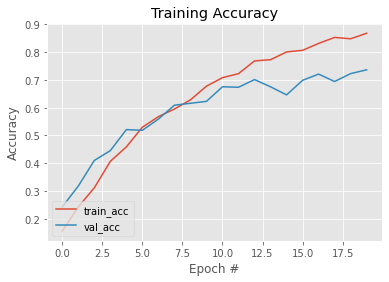

In [20]:
# plot the training accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig('/drive/My Drive/Colab Notebooks/Plots/CNN_Pretrained_V13_ACC.png')

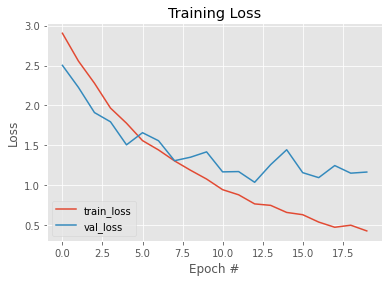

In [21]:
# plot the training loss
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('/drive/My Drive/Colab Notebooks/Plots/CNN_Pretrained_V13_Loss.png')